### Simple Machine Learning Clustering of Devices 

#### Imports

In [274]:
import os
import json
import pandas as pd
import numpy as np
import pickle

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score



import matplotlib.pyplot as plt
import seaborn as sns

from imagehat.identifiers.eixf_attribute_information import EXIF_TAG_DICT_REV, GPS_TAG_DICT_REV, INTEROP_TAG_DICT_REV

#### Preprocessing


In [275]:
json_folder = os.path.join(".", "temp_divnoise_data", "Canon1", "metadata.json")

dresden_folder = os.path.join("datasets", "json_datasets", "dresden_images", "dresden_metadata.json") 

with open(dresden_folder, "r") as f:
    json_dataset = json.load(f)

json_dataset = {k.split("\\")[-1]: v for k, v in json_dataset.items()}


In [276]:
# LAST two parts removed (_0_48387.JPG)
device_names = []

for file_name in json_dataset.keys():

    file_name = file_name.replace('.JPG', '').replace('.jpg', '')
    
    parts = file_name.split('_')
    
    device_name = '_'.join(parts[:-2])
    
    device_names.append(device_name)

unique_devices = set(device_names)
device_count = len(unique_devices)

print("Extracted Device Names:", sorted(unique_devices))
print("Number of Unique Devices:", device_count)
print("Number of Unique Images:", len(json_dataset.keys()))


Extracted Device Names: ['Agfa_DC-504', 'Agfa_DC-733s', 'Agfa_DC-830i', 'Agfa_Sensor505-x', 'Agfa_Sensor530s', 'Canon_Ixus55', 'Canon_Ixus70', 'Canon_PowerShotA640', 'Casio_EX-Z150', 'FujiFilm_FinePixJ50', 'Kodak_M1063', 'Nikon_CoolPixS710', 'Nikon_D200', 'Nikon_D70', 'Nikon_D70s', 'Olympus_mju_1050SW', 'Panasonic_DMC-FZ50', 'Pentax_OptioA40', 'Pentax_OptioW60', 'Praktica_DCZ5.9', 'Ricoh_GX100', 'Rollei_RCP-7325XS', 'Samsung_L74wide', 'Samsung_NV15', 'Sony_DSC-H50', 'Sony_DSC-T77', 'Sony_DSC-W170']
Number of Unique Devices: 27
Number of Unique Images: 16961


In [ ]:
list_images = json_dataset.keys()
images_per_device = {}

def remove_extension(filename):
    no_ext = os.path.splitext(filename)[0]
    return no_ext.rsplit('_', 1)[0]           


device_feature = list(map(remove_extension, list_images))
unique_models = set(device_feature)
print("Unique Models:", len(unique_models))
print("Unique Models:", sorted(unique_models))


Unique Models: 74
['Agfa_DC-504_0', 'Agfa_DC-733s_0', 'Agfa_DC-830i_0', 'Agfa_Sensor505-x_0', 'Agfa_Sensor530s_0', 'Canon_Ixus55_0', 'Canon_Ixus70_0', 'Canon_Ixus70_1', 'Canon_Ixus70_2', 'Canon_PowerShotA640_0', 'Casio_EX-Z150_0', 'Casio_EX-Z150_1', 'Casio_EX-Z150_2', 'Casio_EX-Z150_3', 'Casio_EX-Z150_4', 'FujiFilm_FinePixJ50_0', 'FujiFilm_FinePixJ50_1', 'FujiFilm_FinePixJ50_2', 'Kodak_M1063_0', 'Kodak_M1063_1', 'Kodak_M1063_2', 'Kodak_M1063_3', 'Kodak_M1063_4', 'Nikon_CoolPixS710_0', 'Nikon_CoolPixS710_1', 'Nikon_CoolPixS710_2', 'Nikon_CoolPixS710_3', 'Nikon_CoolPixS710_4', 'Nikon_D200_0', 'Nikon_D200_1', 'Nikon_D70_0', 'Nikon_D70_1', 'Nikon_D70s_0', 'Nikon_D70s_1', 'Olympus_mju_1050SW_0', 'Olympus_mju_1050SW_1', 'Olympus_mju_1050SW_2', 'Olympus_mju_1050SW_3', 'Olympus_mju_1050SW_4', 'Panasonic_DMC-FZ50_0', 'Panasonic_DMC-FZ50_1', 'Panasonic_DMC-FZ50_2', 'Pentax_OptioA40_0', 'Pentax_OptioA40_1', 'Pentax_OptioA40_2', 'Pentax_OptioA40_3', 'Pentax_OptioW60_0', 'Praktica_DCZ5.9_0', 'Prakt

['Panasonic', 'Sony', 'Samsung', 'Kodak', 'Nikon', 'Olympus', 'Olympus', 'Samsung', 'Sony', 'Pentax', 'Rollei', 'Agfa', 'Rollei', 'Agfa', 'Nikon', 'Nikon', 'Praktica', 'Nikon', 'Kodak', 'Samsung', 'Praktica', 'Ricoh', 'Casio', 'Nikon', 'Sony', 'Praktica', 'Sony', 'Agfa', 'Sony', 'Praktica', 'Canon', 'Nikon', 'Casio', 'Canon', 'Praktica', 'Canon', 'Agfa', 'Agfa', 'FujiFilm', 'Pentax', 'Canon', 'Ricoh', 'Ricoh', 'Samsung', 'Casio', 'Nikon', 'Olympus', 'Sony', 'Nikon', 'Ricoh', 'Casio', 'Sony', 'FujiFilm', 'Pentax', 'Kodak', 'Ricoh', 'Kodak', 'Pentax', 'Pentax', 'Sony', 'Olympus', 'Samsung', 'Olympus', 'Samsung', 'Nikon', 'Panasonic', 'Casio', 'Nikon', 'Kodak', 'Nikon', 'Rollei', 'Panasonic', 'FujiFilm', 'Canon']


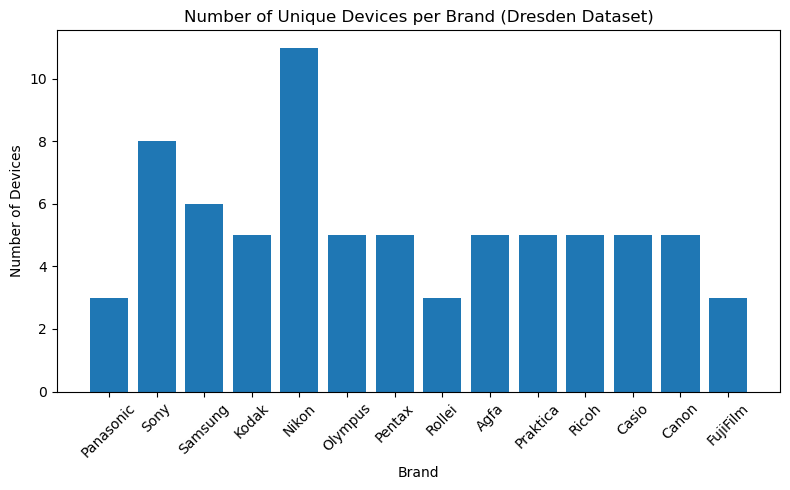

In [344]:
brands = [model.split('_')[0] for model in unique_models]
print(brands)

brand_counts = Counter(brands)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(brand_counts.keys(), brand_counts.values())
plt.xticks(rotation=45)
plt.xlabel("Brand")
plt.ylabel("Number of Devices")
plt.title("Number of Unique Devices per Brand (Dresden Dataset)")
plt.tight_layout()
plt.show()

In [345]:
def get_baseline_tags(tag_dict) -> list:
    sorted_keys = sorted(tag_dict.keys(), key=lambda x: int.from_bytes(x, 'big'))
    tag_names = [tag_dict[k] for k in sorted_keys]
    dec_values = [int.from_bytes(k, 'big') for k in sorted_keys]
    return dec_values, tag_names

In [346]:
exif_values, exif_baseline = get_baseline_tags(EXIF_TAG_DICT_REV)
gps_values, gps_baseline = get_baseline_tags(GPS_TAG_DICT_REV)
interop_values, interop_baseline = get_baseline_tags(INTEROP_TAG_DICT_REV)


In [347]:
print("EXIF Baseline:", exif_baseline)
print("GPS Baseline:", gps_baseline) 
print("Interop Baseline:", interop_baseline)

EXIF Baseline: ['ExposureTime', 'FNumber', 'ExposureProgram', 'SpectralSensitivity', 'PhotographicSensitivity', 'OECF', 'SensitivityType', 'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed', 'ISOSpeedLatitudeyyy', 'ISOSpeedLatitudezzz', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'OffsetTime', 'OffsetTimeOriginal', 'OffsetTimeDigitized', 'ComponentsConfiguration', 'CompressedBitsPerPixel', 'ShutterSpeedValue', 'ApertureValue', 'BrightnessValue', 'ExposureBiasValue', 'MaxApertureValue', 'SubjectDistance', 'MeteringMode', 'LightSource', 'Flash', 'FocalLength', 'SubjectArea', 'MakerNote', 'UserComment', 'SubSecTime', 'SubSecTimeOriginal', 'SubSecTimeDigitized', 'Temperature', 'Humidity', 'Pressure', 'WaterDepth', 'Acceleration', 'CameraElevationAngle', 'FlashpixVersion', 'ColorSpace', 'PixelXDimension', 'PixelYDimension', 'RelatedSoundFile', 'InteroperabilityIFDPointer', 'FlashEnergy', 'SpatialFrequencyResponse', 'FocalPlaneXResolution', 'FocalPlaneYResolution

In [348]:
print("Verify Ascending Order:")
print("EXIF baseline:", exif_baseline)
print("EXIF values:", exif_values)
print("GPS values:", gps_values)
print("Interop values:", interop_values)

Verify Ascending Order:
EXIF baseline: ['ExposureTime', 'FNumber', 'ExposureProgram', 'SpectralSensitivity', 'PhotographicSensitivity', 'OECF', 'SensitivityType', 'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed', 'ISOSpeedLatitudeyyy', 'ISOSpeedLatitudezzz', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'OffsetTime', 'OffsetTimeOriginal', 'OffsetTimeDigitized', 'ComponentsConfiguration', 'CompressedBitsPerPixel', 'ShutterSpeedValue', 'ApertureValue', 'BrightnessValue', 'ExposureBiasValue', 'MaxApertureValue', 'SubjectDistance', 'MeteringMode', 'LightSource', 'Flash', 'FocalLength', 'SubjectArea', 'MakerNote', 'UserComment', 'SubSecTime', 'SubSecTimeOriginal', 'SubSecTimeDigitized', 'Temperature', 'Humidity', 'Pressure', 'WaterDepth', 'Acceleration', 'CameraElevationAngle', 'FlashpixVersion', 'ColorSpace', 'PixelXDimension', 'PixelYDimension', 'RelatedSoundFile', 'InteroperabilityIFDPointer', 'FlashEnergy', 'SpatialFrequencyResponse', 'FocalPlaneXResolution'

In [349]:
print("Control Sizes for feature extraction:")
print("EXIF sizes", len(exif_values))
print("GPS sizes", len(gps_values))
print("Interop sizes", len(interop_values))
print("Feature sizes", len(exif_values)+len(gps_values)+len(interop_values))


Control Sizes for feature extraction:
EXIF sizes 89
GPS sizes 32
Interop sizes 5
Feature sizes 126


#### Creating a DataFrame

In [350]:
# Creating a reference table

reference_df = pd.DataFrame({
    "id": range(1, len(list_images) + 1),
    "image": list(list_images),
})
reference_df.head(5)

,id,image
0,1,Agfa_DC-504_0_1.JPG
1,2,Agfa_DC-504_0_10.JPG
2,3,Agfa_DC-504_0_11.JPG
3,4,Agfa_DC-504_0_12.JPG
4,5,Agfa_DC-504_0_13.JPG


In [351]:
# Making sure all models are present
print(len(device_feature))


# Empty df columns
df = pd.DataFrame({
    "image": list(list_images),
    "device": list(device_feature)
})

df = df.merge(reference_df, on="image", how="left")

df = df[["id", "image", "device"]]

df = df.drop(columns=["image"])



df.head()

16961


,id,device
0,1,Agfa_DC-504_0
1,2,Agfa_DC-504_0
2,3,Agfa_DC-504_0
3,4,Agfa_DC-504_0
4,5,Agfa_DC-504_0


In [352]:
df.isna().sum()

id        0
device    0
dtype: int64

In [353]:
# Categorical features
exif_df = pd.DataFrame(columns=exif_baseline)
gps_df = pd.DataFrame(columns=gps_baseline)
interop_df = pd.DataFrame(columns=interop_baseline)


In [354]:
print("Rows and Cols: ", df.shape)

Rows and Cols:  (16961, 2)


#### Dealing with expected tag pos + Preparing df

In [355]:
# Records the expected psoiton for each tag in the baseline
exif_baseline_position = {tag: idx for idx, tag in enumerate(exif_baseline)}
gps_baseline_position = {tag: idx for idx, tag in enumerate(gps_baseline)}
interop_baseline_position = {tag: idx for idx, tag in enumerate(interop_baseline)}



In [356]:
# Records 

observed_exif, observed_gps, observed_interop, observed_metrics = [], [], [], []

temp = []
images = list(json_dataset.keys())
for img in images:
    file_metadata = json_dataset.get(img, {})
    app1_info = file_metadata.get("APP1 Info", {})

    exif_data = app1_info.get("EXIF IFD Data", {})
    gps_data = app1_info.get("GPS IFD Data", {})
    interop_data = app1_info.get("Interop IFD Data", {})

    metrics = file_metadata.get("Metrics", {})

    exif_order = {tag: exif_data[tag].get("IFD Tag Order", None) for tag in exif_data}
    gps_order = {tag: gps_data[tag].get("IFD Tag Order", None) for tag in gps_data}
    interop_order = {tag: interop_data[tag].get("IFD Tag Order", None) for tag in interop_data}

    metrics_per_image = {k: v for k, v in metrics.items()}

    observed_exif.append(exif_order)
    observed_gps.append(gps_order)
    observed_interop.append(interop_order)
    observed_metrics.append(metrics_per_image)

In [357]:
print(observed_metrics[0])

{'Header VAL': 1.0, 'Tag VAL Score': 0.77632, 'Weak Tag Order Score': {'EXIF': 0.78464, 'Interop': 1.0}, 'Strict Tag Order Score': {'EXIF': 0.97937, 'Interop': 1.0}, 'EXIF Conformity Score': 0.84675}


In [358]:
# Prepare empty lists first
exif_rows = []
gps_rows = []
interop_rows = []
ecs_rows = []

# Build rows without touching the DataFrame yet
for order_dict in observed_exif:
    row = {tag: order_dict.get(tag, None) for tag in exif_baseline}
    exif_rows.append(row)

for order_dict in observed_gps:
    row = {tag: order_dict.get(tag, None) for tag in gps_baseline}
    gps_rows.append(row)

for order_dict in observed_interop:
    row = {tag: order_dict.get(tag, None) for tag in interop_baseline}
    interop_rows.append(row)

for metric in observed_metrics:
    row = {k: metric.get(k, None) for k in metric.keys() if k == "EXIF Conformity Score"}
    ecs_rows.append(row)


In [359]:
# Working dfs for later concat

exif_df = pd.DataFrame(exif_rows)
gps_df = pd.DataFrame(gps_rows)
interop_df = pd.DataFrame(interop_rows)
ecs_df = pd.DataFrame(ecs_rows)

ecs_df.head()

,EXIF Conformity Score
0,0.84675
1,0.84675
2,0.84675
3,0.84675
4,0.84675


In [360]:
exif_df.isna().sum()

ExposureTime                               0
FNumber                                    0
ExposureProgram                         1171
SpectralSensitivity                    16961
PhotographicSensitivity                 1148
                                       ...  
MetadataEditingSoftware                16961
CompositeImage                         16961
SourceImageNumberOfCompositeImage      16961
SourceExposureTimesOfCompositeImage    16961
Gamma                                  16787
Length: 89, dtype: int64

In [361]:
def compute_offsets(df, baseline_position):
    result = df.copy()
    for tag in result.columns:
        expected_pos = baseline_position.get(tag, None)
        if expected_pos is not None:
            result[tag] = result[tag].apply(lambda x: x - expected_pos if pd.notna(x) else np.nan)
    return result


In [362]:
# Computing the offset to their own copy

exif_offsets = compute_offsets(exif_df, exif_baseline_position)
gps_offsets = compute_offsets(gps_df, gps_baseline_position)
interop_offsets = compute_offsets(interop_df, interop_baseline_position)

# Veriying the offsets

row = exif_offsets.iloc[0]   # for the first row
exif_offsets.head()

,ExposureTime,FNumber,ExposureProgram,SpectralSensitivity,PhotographicSensitivity,OECF,SensitivityType,StandardOutputSensitivity,RecommendedExposureIndex,ISOSpeed,...,Photographer,ImageEditor,CameraFirmware,RAWDevelopingSoftware,ImageEditingSoftware,MetadataEditingSoftware,CompositeImage,SourceImageNumberOfCompositeImage,SourceExposureTimesOfCompositeImage,Gamma
0,0,0,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [466]:
# Unscaled features
offset_features = pd.concat([exif_offsets, gps_offsets, interop_offsets, ecs_df], axis=1)

# Labels for testing
final_df = pd.concat([df[["id", "device"]].reset_index(drop=True), offset_features], axis=1)
final_df["model_device"] = final_df["device"].apply(lambda x: '_'.join(x.split('_')[:-1]))

# For visualization
visuals_df = final_df.drop(columns=["id", "device", "model_device"])


# ML features
ml_features = final_df.drop(columns=["id", "device", "model_device"]).fillna(-999)
scaler = StandardScaler()
offset_scaled = pd.DataFrame(scaler.fit_transform(ml_features), columns=ml_features.columns)


# Label columns added
offset_scaled["device"] = final_df["device"].values
offset_scaled["model_device"] = final_df["model_device"].values
offset_scaled["id"] = final_df["id"].values


training_features = offset_scaled.drop(columns=["device", "model_device", "id"])
# training_features_ecs = offset_scaled.drop(columns=["device", "id"])
# training = 
# y_full = offset_scaled["device"]
test_labels = offset_scaled["model_device"]

print(list(training_features.columns))

['ExposureTime', 'FNumber', 'ExposureProgram', 'SpectralSensitivity', 'PhotographicSensitivity', 'OECF', 'SensitivityType', 'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed', 'ISOSpeedLatitudeyyy', 'ISOSpeedLatitudezzz', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'OffsetTime', 'OffsetTimeOriginal', 'OffsetTimeDigitized', 'ComponentsConfiguration', 'CompressedBitsPerPixel', 'ShutterSpeedValue', 'ApertureValue', 'BrightnessValue', 'ExposureBiasValue', 'MaxApertureValue', 'SubjectDistance', 'MeteringMode', 'LightSource', 'Flash', 'FocalLength', 'SubjectArea', 'MakerNote', 'UserComment', 'SubSecTime', 'SubSecTimeOriginal', 'SubSecTimeDigitized', 'Temperature', 'Humidity', 'Pressure', 'WaterDepth', 'Acceleration', 'CameraElevationAngle', 'FlashpixVersion', 'ColorSpace', 'PixelXDimension', 'PixelYDimension', 'RelatedSoundFile', 'InteroperabilityIFDPointer', 'FlashEnergy', 'SpatialFrequencyResponse', 'FocalPlaneXResolution', 'FocalPlaneYResolution', 'FocalPlaneR

In [440]:
dict(visuals_df.isna().sum())

{'ExposureTime': 0,
 'FNumber': 0,
 'ExposureProgram': 1171,
 'SpectralSensitivity': 16961,
 'PhotographicSensitivity': 1148,
 'OECF': 16961,
 'SensitivityType': 16961,
 'StandardOutputSensitivity': 16961,
 'RecommendedExposureIndex': 16961,
 'ISOSpeed': 16961,
 'ISOSpeedLatitudeyyy': 16961,
 'ISOSpeedLatitudezzz': 16961,
 'ExifVersion': 0,
 'DateTimeOriginal': 0,
 'DateTimeDigitized': 0,
 'OffsetTime': 16961,
 'OffsetTimeOriginal': 16961,
 'OffsetTimeDigitized': 16961,
 'ComponentsConfiguration': 0,
 'CompressedBitsPerPixel': 5684,
 'ShutterSpeedValue': 10328,
 'ApertureValue': 8549,
 'BrightnessValue': 15477,
 'ExposureBiasValue': 0,
 'MaxApertureValue': 0,
 'SubjectDistance': 16961,
 'MeteringMode': 0,
 'LightSource': 1809,
 'Flash': 0,
 'FocalLength': 172,
 'SubjectArea': 16961,
 'MakerNote': 0,
 'UserComment': 11956,
 'SubSecTime': 15473,
 'SubSecTimeOriginal': 15473,
 'SubSecTimeDigitized': 15473,
 'Temperature': 16961,
 'Humidity': 16961,
 'Pressure': 16961,
 'WaterDepth': 16961

In [441]:
# Single feature inspection
print(visuals_df["SubjectDistanceRange"].unique()) 
print(offset_scaled["SubjectDistanceRange"].unique()) 

[-36.  nan -35. -34. -38. -31. -32. -41. -42. -40.]
[ 1.0008933  -0.9986343   1.00296966  1.00504601  0.9967406   1.01127507
  1.00919871  0.99051154  0.98843519  0.99258789]


#### Putting it together

In [442]:

# final_df = pd.concat([df[["id", "device"]].reset_index(drop=True), X_features], axis=1)
# final_df["model_device"] = final_df["device"].apply(lambda x: '_'.join(x.split('_')[:-1]))

# final_df.head()

In [453]:
# Number of counts per image

offset_scaled["model_device"].value_counts()


model_device
Kodak_M1063            2391
Olympus_mju_1050SW     1040
Praktica_DCZ5.9        1019
Panasonic_DMC-FZ50      931
Casio_EX-Z150           925
Nikon_CoolPixS710       925
Ricoh_GX100             854
Nikon_D200              752
Sony_DSC-T77            725
Samsung_L74wide         687
Samsung_NV15            645
Pentax_OptioA40         638
FujiFilm_FinePixJ50     630
Rollei_RCP-7325XS       589
Canon_Ixus70            567
Sony_DSC-H50            541
Sony_DSC-W170           405
Agfa_Sensor530s         372
Nikon_D70               369
Nikon_D70s              367
Agfa_DC-830i            363
Agfa_DC-733s            281
Canon_Ixus55            224
Pentax_OptioW60         192
Canon_PowerShotA640     188
Agfa_Sensor505-x        172
Agfa_DC-504             169
Name: count, dtype: int64

#### Some visuals and inspection for the IFD data 

54


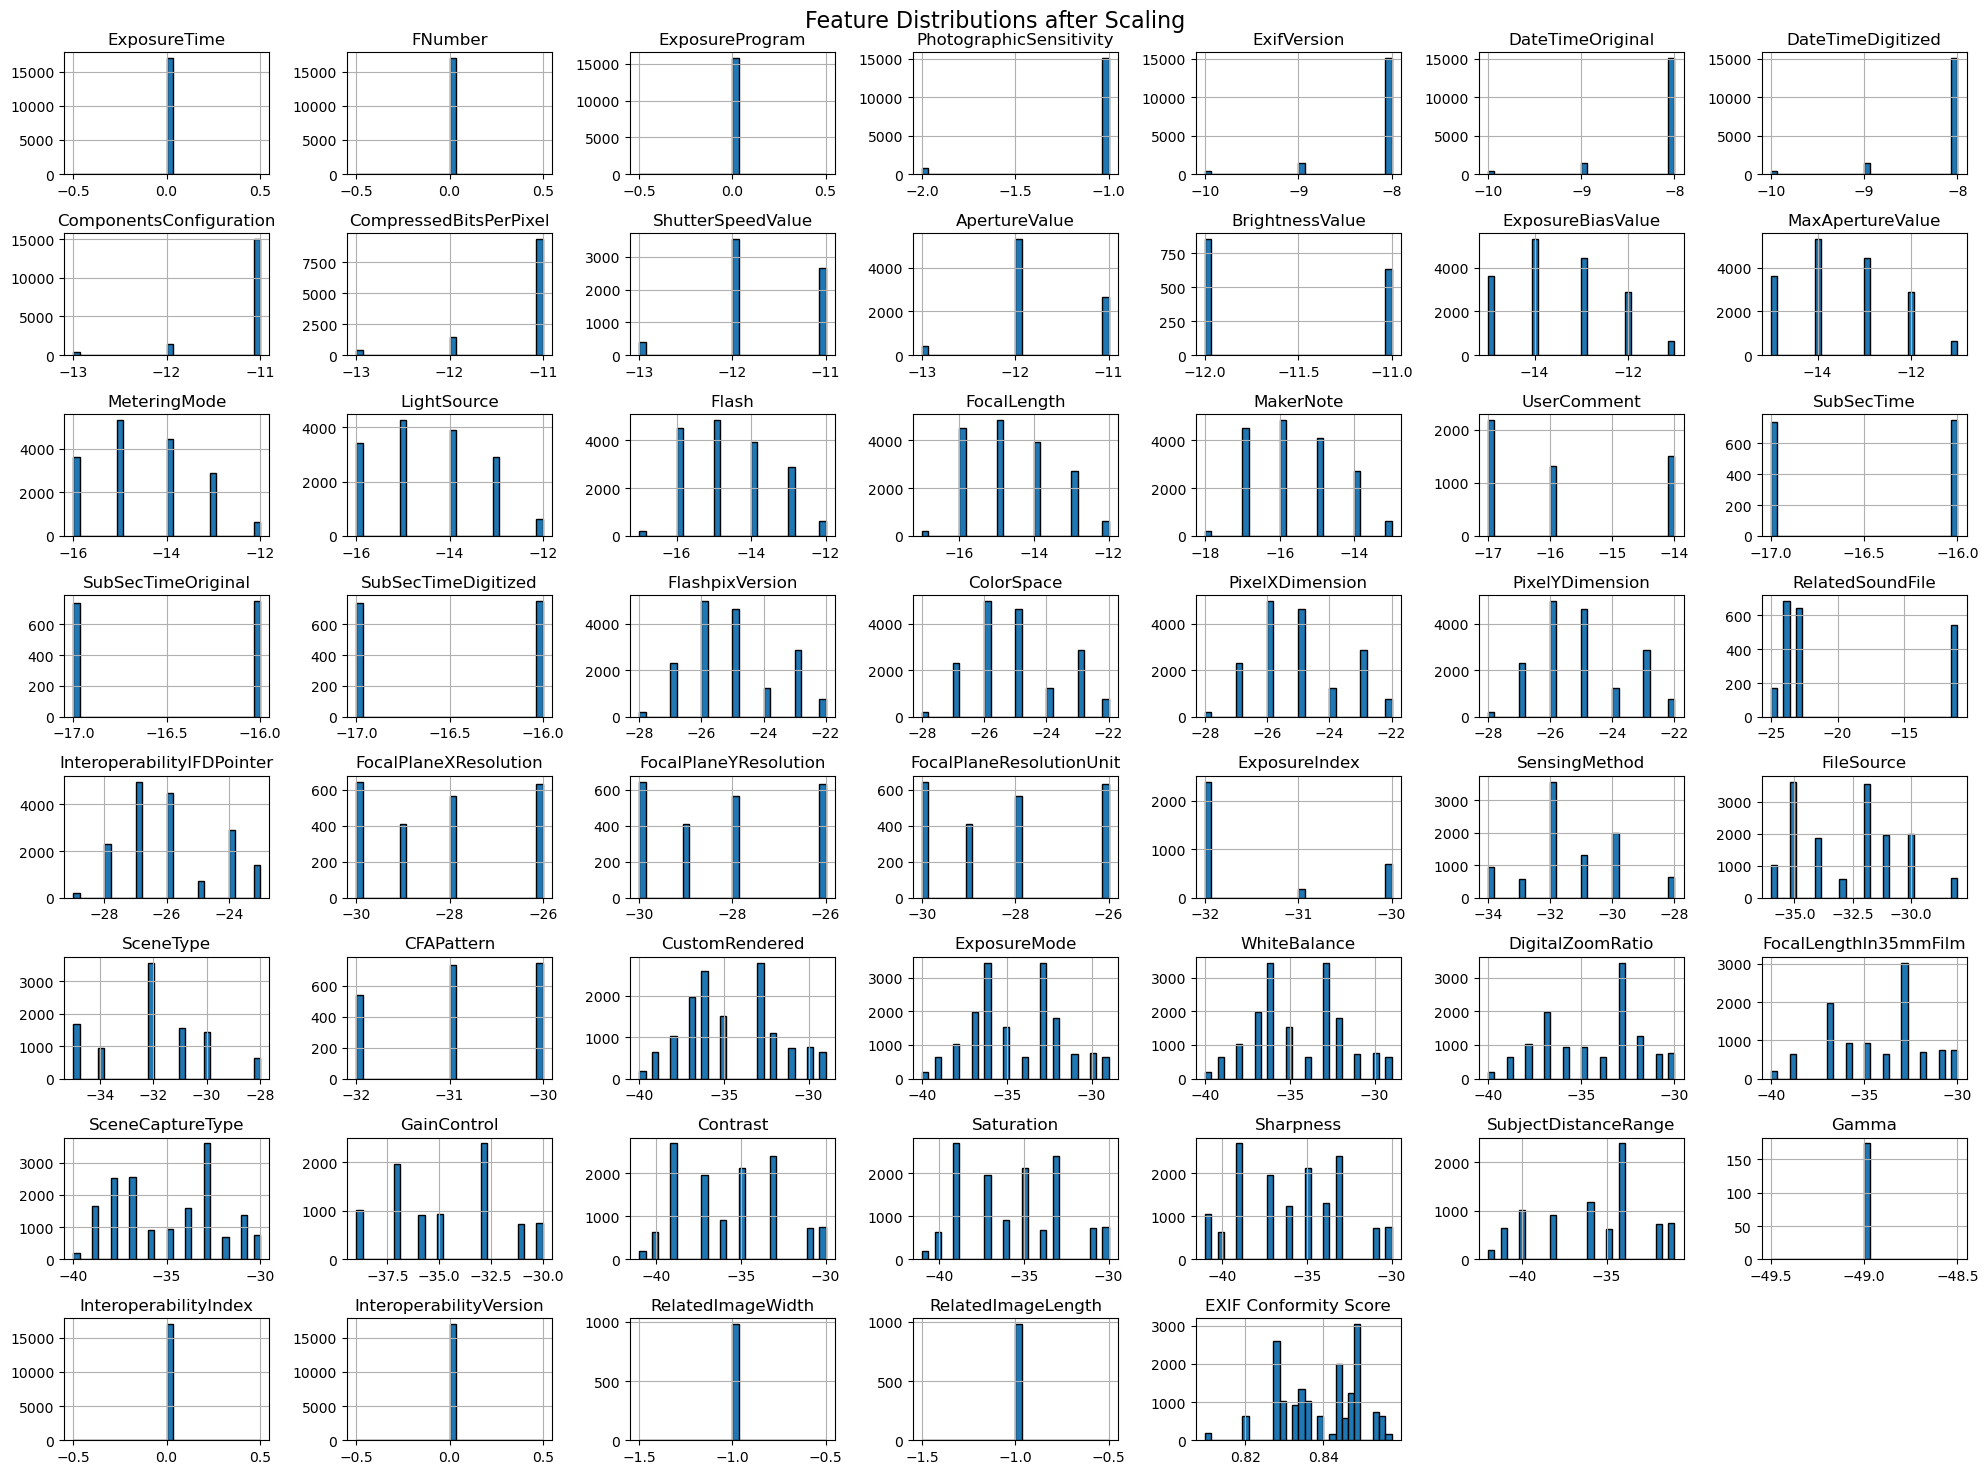

In [454]:
non_nan_df = visuals_df.dropna(axis=1, how='all')
print(len(non_nan_df.columns))

non_nan_df.hist(bins=30, figsize=(20, 15), edgecolor='black')
plt.suptitle('Feature Distributions after Scaling', fontsize=16)
plt.tight_layout()
plt.show()

In [445]:
# Counting non-nan values to show
nan_counts = visuals_df.isna().sum().sum()
non_nan_counts = visuals_df.notna().sum().sum()


print(f"NaN values: {nan_counts}")
print(f"Non-NaN values: {non_nan_counts}")
print(f"Non-NaN percent: {round(non_nan_counts/(non_nan_counts+nan_counts) * 100, 5)}%")



NaN values: 1535718
Non-NaN values: 618329
Non-NaN percent: 28.70546%


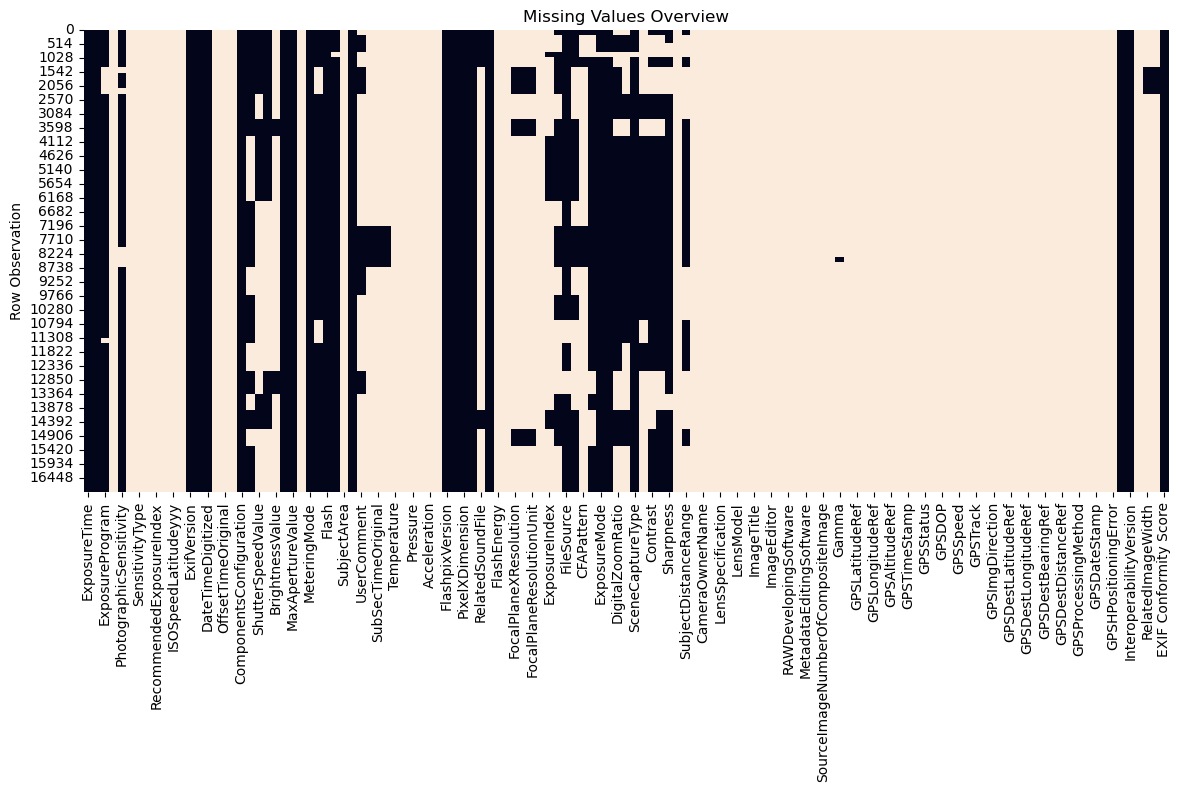

In [448]:

# # Step 1: Get model name per row
# models = final_df['model_device'].values

# # Step 2: Find where model changes
# change_indices = [0]  # Always start with 0
# for i in range(1, len(models)):
#     if models[i] != models[i-1]:
#         change_indices.append(i)

# # Step 3: Extract the model names only once at each change
# new_labels = [models[i] for i in change_indices]

plt.figure(figsize=(14, 6))
sns.heatmap(visuals_df.isna(), cbar=False)
plt.title('Missing Values Overview')
plt.ylabel("Row Observation")
# plt.yticks(ticks=range(len(models)), labels=models, fontsize=6)
plt.yticks()

plt.show()



# Training on Features Only

## Train-Test Split

In [494]:
# Drop label columns from X
X = training_features.drop(columns=["EXIF Conformity Score"])

# Use model-level device attribution as the target
y = test_labels

# Split the dataset for training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (13568, 126)
Test shape: (3393, 126)


## Decision Tree      

In [495]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Predict
y_pred_tree = tree_model.predict(X_test)

# Metrics
print("Decision Tree Results:")
print(classification_report(y_test, y_pred_tree))
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.4f}")

with open("decision_tree_model.pkl", "wb") as f:
    pickle.dump(tree_model, f)

Decision Tree Results:
                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.54      1.00      0.70        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.00      0.00      0.00        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      0.51      0.68        74
         Nikon_D70s       0.67      1.00      0.80        73


c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## K-Nearest Neighbour

In [498]:
knn_model = KNeighborsClassifier(n_neighbors=5)  # 5 neighbors, you can tweak this later
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test)

# Metrics
print("\nKNN Results:")
print(classification_report(y_test, y_pred_knn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")

# Save model
with open("knn_model.pkl", "wb") as f:
    pickle.dump(knn_model, f)



KNN Results:
                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.00      0.00      0.00        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.46      1.00      0.63        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      0.51      0.68        74
         Nikon_D70s       0.67      1.00      0.80        73
 Olympus_

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


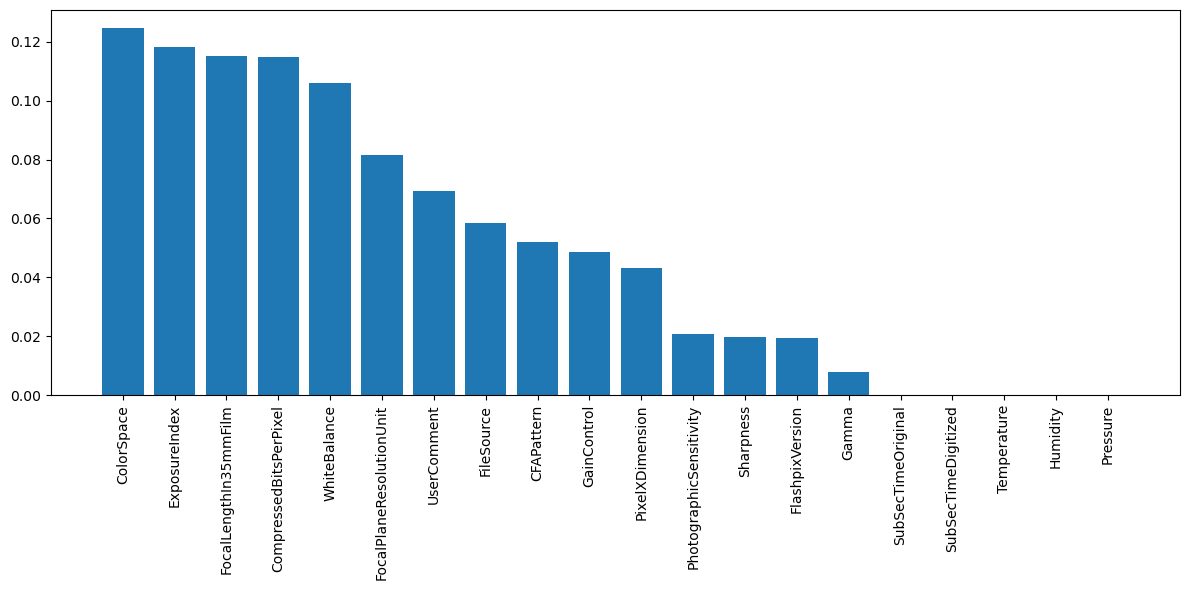

In [500]:
importances = tree_model.feature_importances_

# Sort
indices = importances.argsort()[::-1]
feature_names = X_train.columns

# Plot
plt.figure(figsize=(12,6))
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

# Training ECS Metric Only

In [485]:
X_ecs = offset_scaled[["EXIF Conformity Score"]]
print(X_ecs)
y_ecs = offset_scaled["model_device"]

# Train/test split
X_train_ecs, X_test_ecs, y_train_ecs, y_test_ecs = train_test_split(
    X_ecs, y_ecs, test_size=0.2, random_state=42, stratify=y_ecs
)

       EXIF Conformity Score
0                   0.746069
1                   0.746069
2                   0.746069
3                   0.746069
4                   0.746069
...                      ...
16956              -1.129956
16957              -1.129956
16958              -1.129956
16959              -1.129956
16960              -1.129956

[16961 rows x 1 columns]


In [478]:

# Train a simple decision tree
clf_ecs = DecisionTreeClassifier(random_state=42)
clf_ecs.fit(X_train_ecs, y_train_ecs)

# Predict and evaluate
y_pred_ecs = clf_ecs.predict(X_test_ecs)

print("ECS-only Model Performance")
print(classification_report(y_test_ecs, y_pred_ecs))
print(f"Accuracy: {accuracy_score(y_test_ecs, y_pred_ecs):.4f}")


ECS-only Model Performance
                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.54      1.00      0.70        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.00      0.00      0.00        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      0.51      0.68        74
         Nikon_D70s       0.67      1.00      0.80       

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Training on Both Features

In [ ]:
X = training_features
y = offset_scaled["model_device"]

# Split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Index(['ExposureTime', 'FNumber', 'ExposureProgram', 'SpectralSensitivity',
       'PhotographicSensitivity', 'OECF', 'SensitivityType',
       'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed',
       ...
       'GPSAreaInformation', 'GPSDateStamp', 'GPSDifferential',
       'GPSHPositioningError', 'InteroperabilityIndex',
       'InteroperabilityVersion', 'RelatedImageFileFormat',
       'RelatedImageWidth', 'RelatedImageLength', 'EXIF Conformity Score'],
      dtype='object', length=127)


In [ ]:
clf_full = DecisionTreeClassifier(random_state=42)
clf_full.fit(X_train_full, y_train_full)


y_pred_full = clf_full.predict(X_test_full)

print("Full Feature Model Performance")
print(classification_report(y_test_full, y_pred_full))
print(f"Accuracy: {accuracy_score(y_test_full, y_pred_full):.4f}")


Full Feature Model Performance
                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.54      1.00      0.70        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.00      0.00      0.00        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      0.51      0.68        74
         Nikon_D70s       0.67      1.00      0.80   

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


IndexError: index 126 is out of bounds for axis 0 with size 126

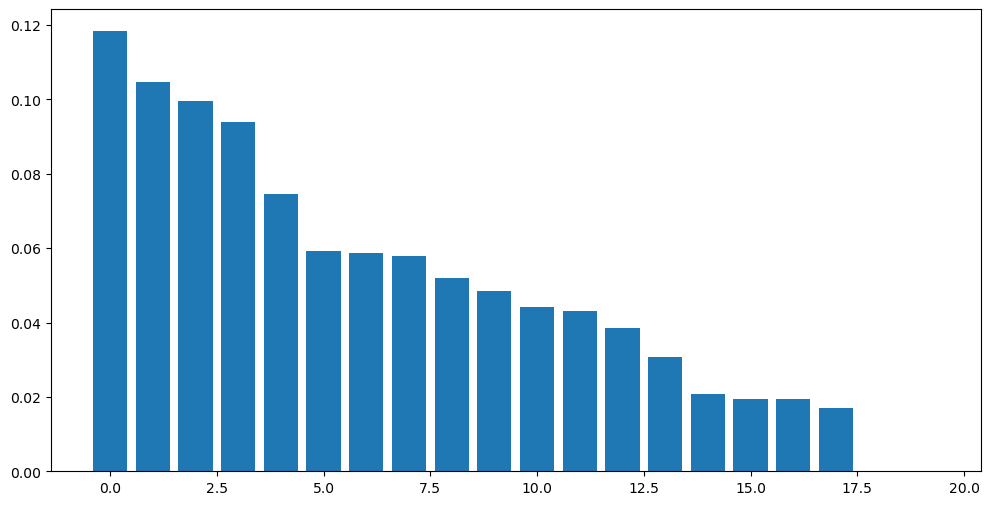

In [502]:
importances = clf_full.feature_importances_

# Sort
indices = importances.argsort()[::-1]
feature_names = X_train.columns

# Plot
plt.figure(figsize=(12,6))
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()